# SENet

### 背景
- **提出时间**：2017年由Momenta团队提出，发表于CVPR 2018，并获得 **ImageNet 2017分类竞赛冠军**。
- **核心问题**：传统CNN的卷积操作平等对待所有通道（channel），但不同通道的特征重要性实际存在差异。例如，某些通道可能编码背景噪声，而另一些编码关键语义特征。

### ImageNet 结果
- **Top-5错误率**：SENet-154（基于ResNeXt）达到 **2.251%**，超越同期其他模型（如DPN、NASNet）。
- **轻量版性能**：SE-ResNet-50仅增加约2%的计算量，但错误率相对下降10%以上。

### 解决的问题
- **通道间依赖关系建模**：通过动态学习通道权重，增强重要特征通道，抑制冗余通道。
- **计算效率**：在几乎不增加计算成本的前提下提升模型性能。

---

### 创新性

1. **Squeeze-and-Excitation（SE）模块**：
   - **Squeeze**：全局平均池化（GAP）压缩空间维度（H×W→1×1），生成通道描述符。
   - **Excitation**：通过全连接层（含ReLU和Sigmoid）学习通道间非线性关系，输出各通道的权重（0~1）。
   - **Scale**：将权重与原特征图逐通道相乘，实现特征重校准。

![alt text](resources/senet_arch.png "Title")


2. **即插即用设计**：
   SE模块可嵌入任何现有CNN架构（如ResNet、Inception、MobileNet），仅需少量代码修改。


![alt text](resources/senet_detail.png "Title")


### 对当代CNN的影响

1. **注意力机制的普及**：
   - SENet是首个将 **通道注意力（Channel Attention）** 引入主流CNN的工作，启发了后续的CBAM（空间+通道注意力）、ECA-Net（高效通道注意力）等。
   - 推动了"注意力即基础模块"的范式转变（如Transformer中的Self-Attention）。

2. **轻量化设计的标杆**：
   - 证明通过智能特征重校准（而非单纯增加深度/宽度）可显著提升模型效率，影响MobileNetV3、EfficientNet等轻量模型的设计。

3. **跨领域应用**：
   - 医学图像（如病灶区域增强）、目标检测（如SE-FasterRCNN）、视频分析等均验证了SE模块的泛用性。

## SE模块实现
SE模块和使用都非常简单,即插即用.
```python
class SqueezeExcitation(nn.Module):
    """Pluggable Squeeze-Excitation Module."""

    def __init__(self, channel: int, reduction_ratio: int) -> None:
        """Init.

        Args:
            channel: Number of channels.
            reduction_ratio: Reduction ratio for the internal FC layer.
        """
        fc_channel = channel // reduction_ratio
        if fc_channel * reduction_ratio != channel:
            raise ValueError("Channel is not divisible by reduction ratio.")
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            # 使用1x1卷积来模拟Linear
            nn.Conv2d(channel, fc_channel, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(fc_channel, channel, kernel_size=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return X * self.se(X)
```

一行代码即将其应用到Resnet的Bottleneck模块上:
```python

class SEBottleneckBlock(nn.Module):
    def __init__(...) -> None:
        ...
        self.resbranch = nn.Sequential(
            _Conv2d(in_channel, bottleneck_channel, activation=True, kernel_size=1, padding=0),
            _Conv2d(bottleneck_channel, bottleneck_channel, activation=True, kernel_size=3, stride=stride, padding=1),
            _Conv2d(bottleneck_channel, out_channel, activation=False, kernel_size=1, padding=0),
            # 这个SqueezeExcitation模块是唯一和BottleneckBlock不同的地方
            SqueezeExcitation(out_channel, reduction_ratio),
        )
    ...
```

下面对比Resnet50和SE-Resnet50两个网络

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader

TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomRotation(10),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=train_dataset_transforms,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=val_dataset_transforms,
)


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader

### Resnet50

In [3]:
from spacy import training
from hdd.models.cnn.resnet import Resnet, resnet50_config
from hdd.train.early_stopping import EarlyStoppingInMem
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    resnet_config,
    train_dataloader,
    val_dataloader,
    dropout,
    lr,
    weight_decay,
    step_size=40,
    gamma=0.1,
    patience=40,
    max_epochs=160,
) -> tuple[Resnet, dict[str, list[float]]]:
    net = Resnet(resnet_config, num_classes=10, dropout=dropout).to(DEVICE)
    criteria = nn.CrossEntropyLoss()
    # SGD的效果远不如Adam好
    # optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.AdamW(
        net.parameters(), lr=lr, eps=1e-6, weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=step_size, gamma=gamma, last_epoch=-1
    )
    early_stopper = EarlyStoppingInMem(patience=patience, verbose=False)
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        early_stopper,
        verbose=True,
    )
    return net, training_stats


train_dataloader, val_dataloader = build_dataloader(128, train_dataset, val_dataset)
net, resnet50_stats = train_net(
    resnet50_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-4,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/160 Train Loss: 2.4258 Accuracy: 0.2116 Time: 16.74283  | Val Loss: 2.0407 Accuracy: 0.2764
Epoch: 2/160 Train Loss: 1.8985 Accuracy: 0.3391 Time: 15.66259  | Val Loss: 1.7327 Accuracy: 0.4270
Epoch: 3/160 Train Loss: 1.6758 Accuracy: 0.4298 Time: 16.18152  | Val Loss: 1.7336 Accuracy: 0.4354
Epoch: 4/160 Train Loss: 1.5121 Accuracy: 0.4934 Time: 16.27642  | Val Loss: 1.3863 Accuracy: 0.5445
Epoch: 5/160 Train Loss: 1.3883 Accuracy: 0.5411 Time: 16.02157  | Val Loss: 1.3551 Accuracy: 0.5615
Epoch: 6/160 Train Loss: 1.2680 Accuracy: 0.5869 Time: 16.21739  | Val Loss: 1.3528 Accuracy: 0.5944
Epoch: 7/160 Train Loss: 1.1834 Accuracy: 0.6164 Time: 16.08554  | Val Loss: 1.3408 Accuracy: 0.5549
Epoch: 8/160 Train Loss: 1.1112 Accuracy: 0.6421 Time: 16.65766  | Val Loss: 1.1828 Accuracy: 0.6359
Epoch: 9/160 Train Loss: 1.0445 Accuracy: 0.6625 Time: 16.24557  | Val Loss: 0.8663 Accuracy: 0.7231
Epoch: 10/160 Train Loss: 1.0128 Accuracy: 0.6769 Time: 16.25455  | Val Loss: 1.0816 Accura

### SEResnet-50

In [4]:
from hdd.models.cnn.resnet import se_resnet50_config

net, se_resnet50_stats = train_net(
    se_resnet50_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.005,
    weight_decay=1e-4,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/160 Train Loss: 1.9854 Accuracy: 0.3185 Time: 19.05724  | Val Loss: 1.6836 Accuracy: 0.4273
Epoch: 2/160 Train Loss: 1.6439 Accuracy: 0.4401 Time: 19.38730  | Val Loss: 1.5655 Accuracy: 0.4650
Epoch: 3/160 Train Loss: 1.4149 Accuracy: 0.5304 Time: 19.25748  | Val Loss: 1.8216 Accuracy: 0.4479
Epoch: 4/160 Train Loss: 1.2618 Accuracy: 0.5838 Time: 19.47411  | Val Loss: 1.1348 Accuracy: 0.6326
Epoch: 5/160 Train Loss: 1.1586 Accuracy: 0.6194 Time: 19.44161  | Val Loss: 1.0522 Accuracy: 0.6670
Epoch: 6/160 Train Loss: 1.0450 Accuracy: 0.6597 Time: 19.38560  | Val Loss: 1.1841 Accuracy: 0.6094
Epoch: 7/160 Train Loss: 1.0015 Accuracy: 0.6773 Time: 19.46964  | Val Loss: 1.0668 Accuracy: 0.6596
Epoch: 8/160 Train Loss: 0.9163 Accuracy: 0.7018 Time: 19.24141  | Val Loss: 1.1453 Accuracy: 0.6346
Epoch: 9/160 Train Loss: 0.8665 Accuracy: 0.7215 Time: 19.47773  | Val Loss: 0.9451 Accuracy: 0.7024
Epoch: 10/160 Train Loss: 0.8273 Accuracy: 0.7328 Time: 19.42424  | Val Loss: 0.8375 Accura

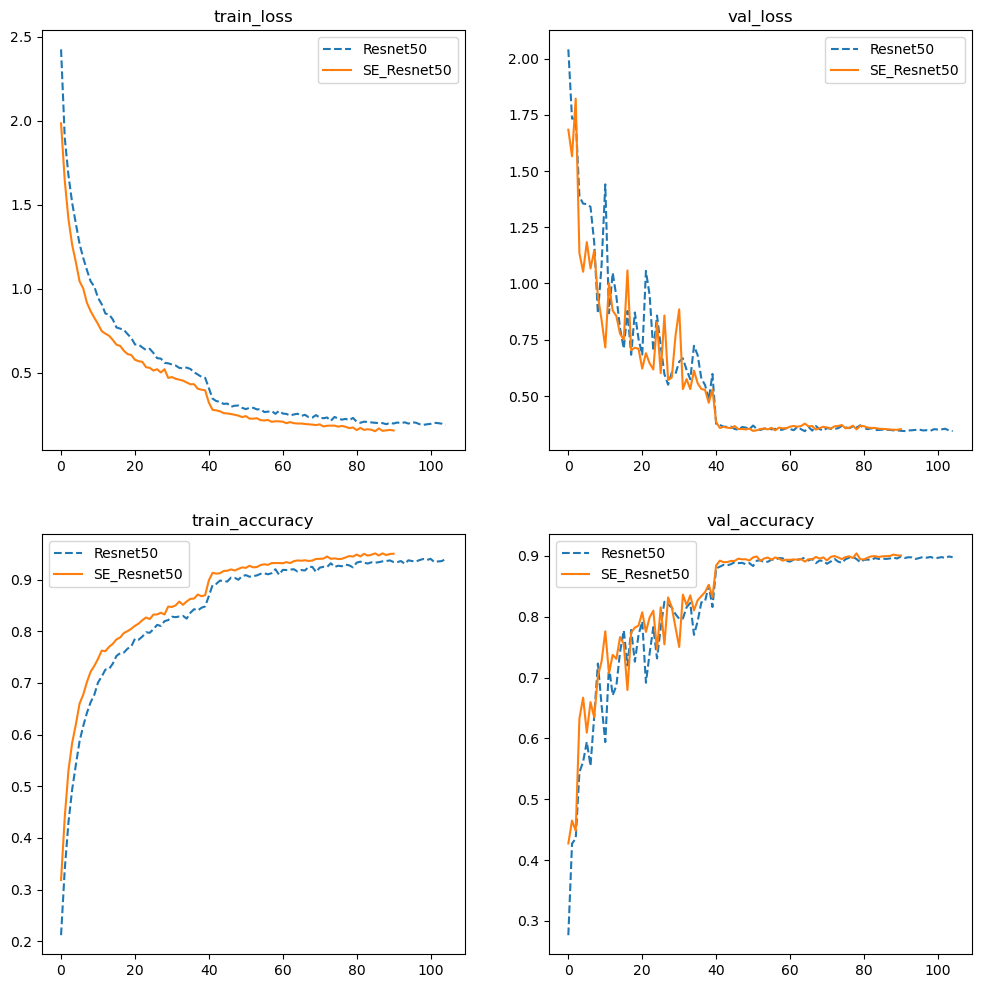

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = resnet50_stats.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(resnet50_stats[field], label="Resnet50", linestyle="--")
    plt.plot(se_resnet50_stats[field], label="SE_Resnet50")
    plt.legend()
    plt.title(field)